In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-23 10:14:04.949676: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:14:05.578461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-23 10:14:05.578548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-23 10:14:05.578556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
initial_measurements = {}
final_measurements = {}
for file in os.listdir('/home/hpinkard_waller/data/lung_meld_measurements_non_blank_data'):
    if file.endswith('.npy'):
        print(file)
        data = np.load('/home/hpinkard_waller/data/lung_meld_measurements_non_blank_data/' + file)
        # get the number after 'count' in the filename
        count = int(file.split('count')[1].split('iteration')[0])
        initial = 'iteration_0' in file
        if initial:
            initial_measurements[count] = data
        else:
            final_measurements[count] = data
print(initial_measurements.keys())

lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count200iteration_30.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count1000iteration_30.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count400iteration_30.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count400iteration_0.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count1000iteration_0.ptnewLung_measurements.npy
lung_pos_lr0.0003_rad_lr0.0001_thr_lr1.0_net_lr6e-05_step_lr0.0_photon_count200iteration_0.ptnewLung_measurements.npy
dict_keys([400, 1000, 200])


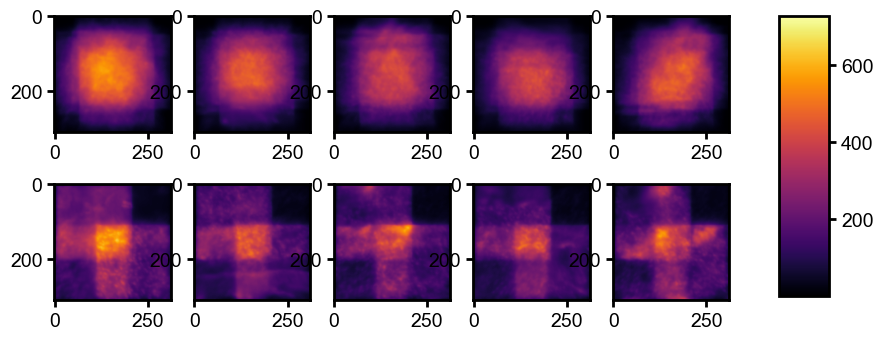

In [3]:
photon_count = 400

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


In [ ]:

# plot the histograms of the initial and final measurements
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(data_min, data_max, 80)

_ = axs.hist(initial_images[:10].ravel(), bins=bins, alpha=0.5)
_ = axs.hist(final_images[:10].ravel(), bins=bins, alpha=0.5)

# Try cropping to center

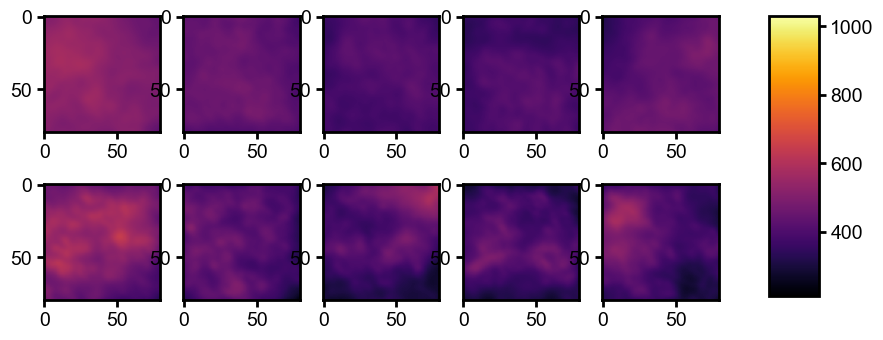

In [5]:
photon_count = 400
crop_size = 80

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

# take center crop_size pixels
initial_images = initial_images[:, initial_images.shape[1] // 2 - crop_size // 2:initial_images.shape[1] // 2 + crop_size // 2, initial_images.shape[2] // 2 - crop_size // 2:initial_images.shape[2] // 2 + crop_size // 2]
final_images = final_images[:, final_images.shape[1] // 2 - crop_size // 2:final_images.shape[1] // 2 + crop_size // 2, final_images.shape[2] // 2 - crop_size // 2:final_images.shape[2] // 2 + crop_size // 2]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


In [6]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [01:24<00:00, 59.33it/s] 
2024-01-22 14:44:47.413454: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 81.04


Epoch 1: 100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


Epoch 1: validation NLL: 4.87


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 32.19it/s]


Epoch 2: validation NLL: 4.69


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 32.98it/s]


Epoch 3: validation NLL: 4.58


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 32.94it/s]


Epoch 4: validation NLL: 4.61


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 32.60it/s]


Epoch 5: validation NLL: 4.59


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 32.05it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 31.06it/s]


Epoch 7: validation NLL: 4.53


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 30.71it/s]


Epoch 9: validation NLL: 4.65


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 31.13it/s]


Epoch 10: validation NLL: 4.54


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 32.45it/s]


Epoch 11: validation NLL: 4.51


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 32.31it/s]


Epoch 12: validation NLL: 4.51


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 32.37it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 31.76it/s]


Epoch 14: validation NLL: 4.62


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 32.06it/s]


Epoch 15: validation NLL: 4.51


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 31.90it/s]


Epoch 16: validation NLL: 4.51


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 31.93it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 31.94it/s]


Epoch 18: validation NLL: 4.52


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 31.94it/s]


Epoch 19: validation NLL: 4.50


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 31.98it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 31.73it/s]


Epoch 21: validation NLL: 4.56


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 31.78it/s]


Epoch 22: validation NLL: 4.53


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


Epoch 23: validation NLL: 4.53


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 31.80it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 31.77it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 30.31it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 31.28it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 31.58it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 31.63it/s]


Epoch 30: validation NLL: 4.53


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 31.73it/s]


Epoch 31: validation NLL: 4.53


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 31.26it/s]


Epoch 32: validation NLL: 4.59


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 32.14it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


Epoch 34: validation NLL: 4.54


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 31.53it/s]


Epoch 35: validation NLL: 4.52


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 36.64it/s]


Epoch 36: validation NLL: 4.50


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


Epoch 38: validation NLL: 4.51


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.53it/s]


Epoch 39: validation NLL: 4.50


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 40: validation NLL: 4.51


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


Epoch 41: validation NLL: 4.53


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch 42: validation NLL: 4.51


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 43: validation NLL: 4.54


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Epoch 44: validation NLL: 4.50


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 45: validation NLL: 4.56


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.57it/s]


Epoch 46: validation NLL: 4.51


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 47: validation NLL: 4.51


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


Epoch 50: validation NLL: 4.51


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 51: validation NLL: 4.50


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 52: validation NLL: 4.50


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 53: validation NLL: 4.50


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 54: validation NLL: 4.50


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


Epoch 55: validation NLL: 4.50


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 56: validation NLL: 4.51


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.82it/s]


Epoch 57: validation NLL: 4.51


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.70it/s]


Epoch 58: validation NLL: 4.52


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 29.21it/s]


Epoch 59: validation NLL: 4.59


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 60: validation NLL: 4.50


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


Epoch 61: validation NLL: 4.50


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.54it/s]


Epoch 62: validation NLL: 4.51


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 63: validation NLL: 4.53


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.72it/s]


Epoch 64: validation NLL: 4.51


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.58it/s]


Epoch 65: validation NLL: 4.52


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 66: validation NLL: 4.57


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 67: validation NLL: 4.52


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 68: validation NLL: 4.51


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.70it/s]


Epoch 69: validation NLL: 4.50


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.70it/s]


Epoch 70: validation NLL: 4.50


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


Epoch 71: validation NLL: 4.51


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 72: validation NLL: 4.50


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 73: validation NLL: 4.50


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 74: validation NLL: 4.50


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 75: validation NLL: 4.53


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


Epoch 76: validation NLL: 4.51


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Epoch 77: validation NLL: 4.50


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 78: validation NLL: 4.50


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


Epoch 79: validation NLL: 4.50


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 36.05it/s]


Epoch 80: validation NLL: 4.50


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 29.72it/s]


Epoch 81: validation NLL: 4.50


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 23.32it/s]


Epoch 82: validation NLL: 4.51


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


Epoch 83: validation NLL: 4.50


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 23.21it/s]


Epoch 84: validation NLL: 4.51


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.22it/s]


Epoch 85: validation NLL: 4.50


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 23.49it/s]


Epoch 86: validation NLL: 4.50


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 23.15it/s]


Epoch 87: validation NLL: 4.51


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 23.03it/s]


Epoch 88: validation NLL: 4.50


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.06it/s]


Epoch 90: validation NLL: 4.50


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 24.11it/s]


Epoch 91: validation NLL: 4.50


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 23.71it/s]


Epoch 92: validation NLL: 4.50


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 23.84it/s]


Epoch 93: validation NLL: 4.52


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 23.81it/s]


Epoch 94: validation NLL: 4.50


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 24.13it/s]


Epoch 95: validation NLL: 4.52


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.16it/s]


Epoch 96: validation NLL: 4.50


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 23.98it/s]


Epoch 97: validation NLL: 4.51


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.29it/s]


Epoch 98: validation NLL: 4.50


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 23.99it/s]


Epoch 99: validation NLL: 4.52


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 100: validation NLL: 4.51


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


Epoch 101: validation NLL: 4.52


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 102: validation NLL: 4.50


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 23.89it/s]


Epoch 103: validation NLL: 4.50


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


Epoch 104: validation NLL: 4.51


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 105: validation NLL: 4.50


Epoch 106: 100%|██████████| 100/100 [00:04<00:00, 24.43it/s]


Epoch 106: validation NLL: 4.50


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 24.18it/s]


Epoch 107: validation NLL: 4.51


Epoch 108: 100%|██████████| 100/100 [00:04<00:00, 24.17it/s]


Epoch 108: validation NLL: 4.50


Epoch 109: 100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Epoch 109: validation NLL: 4.51


Epoch 110: 100%|██████████| 100/100 [00:04<00:00, 24.31it/s]


Epoch 110: validation NLL: 4.51


Epoch 111: 100%|██████████| 100/100 [00:04<00:00, 24.19it/s]


Epoch 111: validation NLL: 4.52


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 24.18it/s]


Epoch 112: validation NLL: 4.50


Epoch 113: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s]


Epoch 113: validation NLL: 4.50


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.12it/s]


Epoch 114: validation NLL: 4.50


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 115: validation NLL: 4.50


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 23.63it/s]


Epoch 116: validation NLL: 4.52


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.26it/s]


Epoch 117: validation NLL: 4.51


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 118: validation NLL: 4.50


Epoch 119: 100%|██████████| 100/100 [00:04<00:00, 23.84it/s]


Epoch 119: validation NLL: 4.52


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.21it/s]


Epoch 120: validation NLL: 4.51


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 121: validation NLL: 4.52


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.34it/s]


Epoch 122: validation NLL: 4.50


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 23.93it/s]


Epoch 123: validation NLL: 4.51


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.08it/s]


Epoch 124: validation NLL: 4.51


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 23.71it/s]


Epoch 125: validation NLL: 4.51


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


Epoch 126: validation NLL: 4.55


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.13it/s]


Epoch 127: validation NLL: 4.53


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.00it/s]


Epoch 128: validation NLL: 4.51


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.22it/s]


Epoch 129: validation NLL: 4.51
Estimated H(Y|X) = 4.435 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.491 differential entropy/pixel
Estimated I(Y;X) = 0.081 bits/pixel
Initial validation NLL: 83.36


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


Epoch 1: validation NLL: 4.87


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


Epoch 2: validation NLL: 4.65


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


Epoch 3: validation NLL: 4.75


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 38.74it/s]


Epoch 4: validation NLL: 4.56


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 37.94it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 37.69it/s]


Epoch 7: validation NLL: 4.59


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.07it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 37.36it/s]


Epoch 10: validation NLL: 4.54


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 37.75it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 40.50it/s]


Epoch 13: validation NLL: 4.53


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 40.70it/s]


Epoch 15: validation NLL: 4.54


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 41.01it/s]


Epoch 16: validation NLL: 4.53


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Epoch 17: validation NLL: 4.53


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 40.58it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 40.70it/s]


Epoch 21: validation NLL: 4.53


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 40.36it/s]


Epoch 22: validation NLL: 4.53


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


Epoch 23: validation NLL: 4.55


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 40.76it/s]


Epoch 24: validation NLL: 4.53


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 40.59it/s]


Epoch 25: validation NLL: 4.63


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 40.70it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 27: validation NLL: 4.60


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 40.91it/s]


Epoch 28: validation NLL: 4.60


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 40.47it/s]


Epoch 29: validation NLL: 4.59


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Epoch 30: validation NLL: 4.55


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 40.52it/s]


Epoch 31: validation NLL: 4.53


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 40.97it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 40.77it/s]


Epoch 33: validation NLL: 4.54


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


Epoch 34: validation NLL: 4.55


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


Epoch 35: validation NLL: 4.56


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 40.64it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 40.88it/s]


Epoch 37: validation NLL: 4.53


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


Epoch 38: validation NLL: 4.54


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 40.77it/s]


Epoch 39: validation NLL: 4.53


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 40.88it/s]


Epoch 40: validation NLL: 4.63


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 40.61it/s]


Epoch 41: validation NLL: 4.54


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 40.60it/s]


Epoch 42: validation NLL: 4.53


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 40.42it/s]


Epoch 43: validation NLL: 4.52


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


Epoch 44: validation NLL: 4.55


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 40.66it/s]


Epoch 45: validation NLL: 4.52


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 41.22it/s]


Epoch 46: validation NLL: 4.54


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 40.85it/s]


Epoch 47: validation NLL: 4.53


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 41.01it/s]


Epoch 48: validation NLL: 4.54


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Epoch 49: validation NLL: 4.57


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


Epoch 52: validation NLL: 4.52


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 41.44it/s]


Epoch 53: validation NLL: 4.53


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


Epoch 54: validation NLL: 4.53


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 41.19it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 40.48it/s]


Epoch 56: validation NLL: 4.52


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


Epoch 57: validation NLL: 4.52


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 40.63it/s]


Epoch 58: validation NLL: 4.52


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 41.00it/s]


Epoch 59: validation NLL: 4.53


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 40.81it/s]


Epoch 60: validation NLL: 4.57


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 61: validation NLL: 4.53


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 40.71it/s]


Epoch 62: validation NLL: 4.53


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 63: validation NLL: 4.53


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 41.16it/s]


Epoch 64: validation NLL: 4.53


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 40.94it/s]


Epoch 65: validation NLL: 4.53


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 40.55it/s]


Epoch 66: validation NLL: 4.52


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 40.23it/s]


Epoch 67: validation NLL: 4.53


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 41.27it/s]


Epoch 68: validation NLL: 4.53


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 40.78it/s]


Epoch 69: validation NLL: 4.52


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 41.11it/s]


Epoch 70: validation NLL: 4.54


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 40.80it/s]


Epoch 71: validation NLL: 4.52


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


Epoch 72: validation NLL: 4.53


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 40.64it/s]


Epoch 73: validation NLL: 4.54


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 41.03it/s]


Epoch 74: validation NLL: 4.53


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 40.77it/s]


Epoch 75: validation NLL: 4.52


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 40.12it/s]


Epoch 76: validation NLL: 4.52


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 77: validation NLL: 4.54


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Epoch 78: validation NLL: 4.52


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 40.79it/s]


Epoch 79: validation NLL: 4.52


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 40.86it/s]


Epoch 80: validation NLL: 4.53


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


Epoch 81: validation NLL: 4.53


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


Epoch 82: validation NLL: 4.52


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 41.08it/s]


Epoch 83: validation NLL: 4.53


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 41.09it/s]


Epoch 84: validation NLL: 4.53


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


Epoch 85: validation NLL: 4.53


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 40.37it/s]


Epoch 86: validation NLL: 4.52


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 39.99it/s]


Epoch 87: validation NLL: 4.53


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 39.97it/s]


Epoch 89: validation NLL: 4.53


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 41.08it/s]


Epoch 90: validation NLL: 4.53


Epoch 91: 100%|██████████| 100/100 [00:02<00:00, 40.36it/s]


Epoch 91: validation NLL: 4.53


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 92: validation NLL: 4.53


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 40.28it/s]


Epoch 93: validation NLL: 4.53


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Epoch 94: validation NLL: 4.52


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 41.06it/s]


Epoch 95: validation NLL: 4.52


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 41.02it/s]


Epoch 96: validation NLL: 4.52


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


Epoch 97: validation NLL: 4.53


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 40.09it/s]


Epoch 98: validation NLL: 4.53


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


Epoch 99: validation NLL: 4.53


Epoch 100: 100%|██████████| 100/100 [00:02<00:00, 40.31it/s]


Epoch 100: validation NLL: 4.54


Epoch 101: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 101: validation NLL: 4.52


Epoch 102: 100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


Epoch 102: validation NLL: 4.53


Epoch 103: 100%|██████████| 100/100 [00:02<00:00, 41.32it/s]


Epoch 103: validation NLL: 4.52


Epoch 104: 100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


Epoch 104: validation NLL: 4.53


Epoch 105: 100%|██████████| 100/100 [00:02<00:00, 41.27it/s]


Epoch 105: validation NLL: 4.52


Epoch 106: 100%|██████████| 100/100 [00:02<00:00, 41.00it/s]


Epoch 106: validation NLL: 4.53


Epoch 107: 100%|██████████| 100/100 [00:02<00:00, 40.81it/s]


Epoch 107: validation NLL: 4.53


Epoch 108: 100%|██████████| 100/100 [00:02<00:00, 40.99it/s]


Epoch 108: validation NLL: 4.54


Epoch 109: 100%|██████████| 100/100 [00:02<00:00, 41.21it/s]


Epoch 109: validation NLL: 4.52


Epoch 110: 100%|██████████| 100/100 [00:02<00:00, 41.28it/s]


Epoch 110: validation NLL: 4.54


Epoch 111: 100%|██████████| 100/100 [00:02<00:00, 40.31it/s]


Epoch 111: validation NLL: 4.52


Epoch 112: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 112: validation NLL: 4.52


Epoch 113: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 113: validation NLL: 4.53


Epoch 114: 100%|██████████| 100/100 [00:02<00:00, 40.10it/s]


Epoch 114: validation NLL: 4.54


Epoch 115: 100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


Epoch 115: validation NLL: 4.53


Epoch 116: 100%|██████████| 100/100 [00:02<00:00, 39.90it/s]


Epoch 116: validation NLL: 4.52


Epoch 117: 100%|██████████| 100/100 [00:02<00:00, 40.36it/s]


Epoch 117: validation NLL: 4.53


Epoch 118: 100%|██████████| 100/100 [00:02<00:00, 40.27it/s]


Epoch 118: validation NLL: 4.52
Estimated H(Y|X) = 4.426 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.502 differential entropy/pixel
Estimated I(Y;X) = 0.109 bits/pixel
Initial MI:  0.08123497
Final MI:  0.108723305


```
Initial MI:  0.08123497
Final MI:  0.108723305
```

# crop to one of the edges

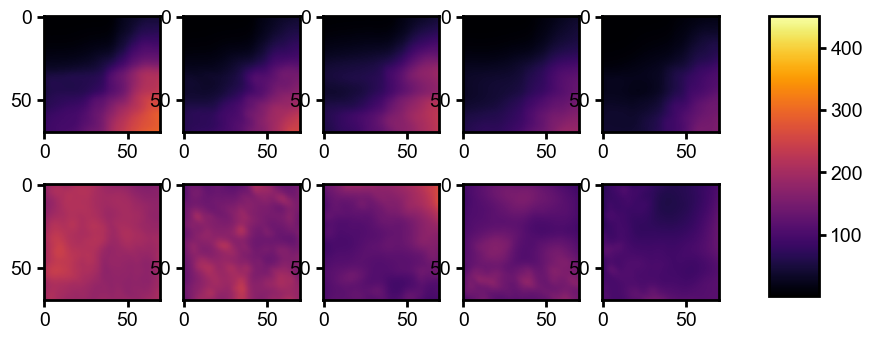

In [13]:
photon_count = 400
# crop_size = 80

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

# take center crop_size pixels
initial_images = initial_images[:, 10:80, 10:80]
final_images = final_images[:, 10:80, 10:80]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


In [14]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [03:20<00:00, 24.98it/s] 


Initial validation NLL: 13.06


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


Epoch 1: validation NLL: 3.88


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 2: validation NLL: 3.60


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 24.13it/s]


Epoch 3: validation NLL: 3.41


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 35.11it/s]


Epoch 4: validation NLL: 3.48


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 21.57it/s]


Epoch 5: validation NLL: 3.71


Epoch 6: 100%|██████████| 100/100 [00:05<00:00, 19.62it/s]


Epoch 6: validation NLL: 3.38


Epoch 7: 100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


Epoch 7: validation NLL: 3.39


Epoch 8: 100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


Epoch 8: validation NLL: 3.37


Epoch 9: 100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


Epoch 9: validation NLL: 3.38


Epoch 10: 100%|██████████| 100/100 [00:05<00:00, 19.59it/s]


Epoch 10: validation NLL: 3.35


Epoch 11: 100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


Epoch 11: validation NLL: 3.41


Epoch 12: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Epoch 12: validation NLL: 3.34


Epoch 13: 100%|██████████| 100/100 [00:05<00:00, 19.67it/s]


Epoch 13: validation NLL: 3.39


Epoch 14: 100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


Epoch 14: validation NLL: 3.39


Epoch 15: 100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


Epoch 15: validation NLL: 3.40


Epoch 16: 100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


Epoch 16: validation NLL: 3.39


Epoch 17: 100%|██████████| 100/100 [00:05<00:00, 19.59it/s]


Epoch 17: validation NLL: 3.45


Epoch 18: 100%|██████████| 100/100 [00:05<00:00, 19.43it/s]


Epoch 18: validation NLL: 3.36


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 19.45it/s]


Epoch 19: validation NLL: 3.42


Epoch 20: 100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


Epoch 20: validation NLL: 3.38


Epoch 21: 100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


Epoch 21: validation NLL: 3.34


Epoch 22: 100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


Epoch 22: validation NLL: 3.34


Epoch 23: 100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


Epoch 23: validation NLL: 3.34


Epoch 24: 100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


Epoch 24: validation NLL: 3.34


Epoch 25: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


Epoch 25: validation NLL: 3.41


Epoch 26: 100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


Epoch 26: validation NLL: 3.34


Epoch 27: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


Epoch 27: validation NLL: 3.37


Epoch 28: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


Epoch 28: validation NLL: 3.34


Epoch 29: 100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


Epoch 29: validation NLL: 3.33


Epoch 30: 100%|██████████| 100/100 [00:05<00:00, 18.45it/s]


Epoch 30: validation NLL: 3.35


Epoch 31: 100%|██████████| 100/100 [00:05<00:00, 18.43it/s]


Epoch 31: validation NLL: 3.35


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


Epoch 32: validation NLL: 3.36


Epoch 33: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Epoch 33: validation NLL: 3.33


Epoch 34: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


Epoch 34: validation NLL: 3.33


Epoch 35: 100%|██████████| 100/100 [00:05<00:00, 18.88it/s]


Epoch 35: validation NLL: 3.35


Epoch 36: 100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


Epoch 36: validation NLL: 3.34


Epoch 37: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


Epoch 37: validation NLL: 3.36


Epoch 38: 100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


Epoch 38: validation NLL: 3.33


Epoch 39: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


Epoch 39: validation NLL: 3.33


Epoch 40: 100%|██████████| 100/100 [00:05<00:00, 18.49it/s]


Epoch 40: validation NLL: 3.32


Epoch 41: 100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


Epoch 41: validation NLL: 3.33


Epoch 42: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


Epoch 42: validation NLL: 3.34


Epoch 43: 100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


Epoch 43: validation NLL: 3.33


Epoch 44: 100%|██████████| 100/100 [00:05<00:00, 18.43it/s]


Epoch 44: validation NLL: 3.36


Epoch 45: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


Epoch 45: validation NLL: 4.68


Epoch 46: 100%|██████████| 100/100 [00:05<00:00, 18.56it/s]


Epoch 46: validation NLL: 4.99


Epoch 47: 100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


Epoch 47: validation NLL: 4.99


Epoch 48: 100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


Epoch 48: validation NLL: 4.99


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 18.28it/s]


Epoch 49: validation NLL: 5.01


Epoch 50: 100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


Epoch 50: validation NLL: 4.99


Epoch 51: 100%|██████████| 100/100 [00:05<00:00, 18.27it/s]


Epoch 51: validation NLL: 4.99


Epoch 52: 100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


Epoch 52: validation NLL: 4.99


Epoch 53: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


Epoch 53: validation NLL: 4.99


Epoch 54: 100%|██████████| 100/100 [00:05<00:00, 19.52it/s]


Epoch 54: validation NLL: 4.99


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


Epoch 55: validation NLL: 4.99


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 26.05it/s]


Epoch 56: validation NLL: 4.99


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 25.97it/s]


Epoch 57: validation NLL: 4.99


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 31.92it/s]


Epoch 58: validation NLL: 4.99


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 38.53it/s]


Epoch 59: validation NLL: 4.99


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 37.81it/s]


Epoch 60: validation NLL: 4.99


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 36.39it/s]


Epoch 61: validation NLL: 4.99


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 22.61it/s]


Epoch 62: validation NLL: 4.99


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 25.78it/s]


Epoch 63: validation NLL: 4.99


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.15it/s]


Epoch 64: validation NLL: 4.99


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch 65: validation NLL: 4.99


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 39.99it/s]


Epoch 66: validation NLL: 4.99


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 40.67it/s]


Epoch 67: validation NLL: 4.99


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 39.94it/s]


Epoch 68: validation NLL: 4.99


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s]


Epoch 69: validation NLL: 4.99


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 32.69it/s]


Epoch 70: validation NLL: 4.99


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 20.95it/s]


Epoch 71: validation NLL: 4.99


Epoch 72: 100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


Epoch 72: validation NLL: 4.99


Epoch 73: 100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


Epoch 73: validation NLL: 4.99


Epoch 74: 100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


Epoch 74: validation NLL: 4.99


Epoch 75: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


Epoch 75: validation NLL: 4.99


Epoch 76: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


Epoch 76: validation NLL: 4.99


Epoch 77: 100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Epoch 77: validation NLL: 4.99


Epoch 78: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


Epoch 78: validation NLL: 4.99


Epoch 79: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


Epoch 79: validation NLL: 4.99


Epoch 80: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


Epoch 80: validation NLL: 4.99
Estimated H(Y|X) = 3.296 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.388 differential entropy/pixel
Estimated I(Y;X) = 0.133 bits/pixel
Initial validation NLL: 24.56


Epoch 1: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


Epoch 1: validation NLL: 4.09


Epoch 2: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


Epoch 2: validation NLL: 4.05


Epoch 3: 100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


Epoch 3: validation NLL: 4.01


Epoch 4: 100%|██████████| 100/100 [00:05<00:00, 18.52it/s]


Epoch 4: validation NLL: 4.07


Epoch 5: 100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


Epoch 5: validation NLL: 4.00


Epoch 6: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


Epoch 6: validation NLL: 3.99


Epoch 7: 100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


Epoch 7: validation NLL: 4.01


Epoch 8: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


Epoch 8: validation NLL: 4.01


Epoch 9: 100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


Epoch 9: validation NLL: 4.00


Epoch 10: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


Epoch 10: validation NLL: 4.00


Epoch 11: 100%|██████████| 100/100 [00:05<00:00, 18.91it/s]


Epoch 11: validation NLL: 4.00


Epoch 12: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


Epoch 12: validation NLL: 4.00


Epoch 13: 100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


Epoch 13: validation NLL: 4.00


Epoch 14: 100%|██████████| 100/100 [00:05<00:00, 18.79it/s]


Epoch 14: validation NLL: 3.98


Epoch 15: 100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


Epoch 15: validation NLL: 3.99


Epoch 16: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Epoch 16: validation NLL: 4.00


Epoch 17: 100%|██████████| 100/100 [00:05<00:00, 19.14it/s]


Epoch 17: validation NLL: 3.98


Epoch 18: 100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


Epoch 18: validation NLL: 3.99


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


Epoch 19: validation NLL: 4.05


Epoch 20: 100%|██████████| 100/100 [00:05<00:00, 18.79it/s]


Epoch 20: validation NLL: 4.01


Epoch 21: 100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


Epoch 21: validation NLL: 4.00


Epoch 22: 100%|██████████| 100/100 [00:05<00:00, 18.55it/s]


Epoch 22: validation NLL: 3.98


Epoch 23: 100%|██████████| 100/100 [00:05<00:00, 18.35it/s]


Epoch 23: validation NLL: 3.99


Epoch 24: 100%|██████████| 100/100 [00:05<00:00, 18.49it/s]


Epoch 24: validation NLL: 3.98


Epoch 25: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


Epoch 25: validation NLL: 3.98


Epoch 26: 100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


Epoch 26: validation NLL: 4.02


Epoch 27: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


Epoch 27: validation NLL: 3.98


Epoch 28: 100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


Epoch 28: validation NLL: 3.98


Epoch 29: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


Epoch 29: validation NLL: 4.01


Epoch 30: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


Epoch 30: validation NLL: 3.98


Epoch 31: 100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


Epoch 31: validation NLL: 3.99


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


Epoch 32: validation NLL: 4.00


Epoch 33: 100%|██████████| 100/100 [00:05<00:00, 19.40it/s]


Epoch 33: validation NLL: 3.98


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 21.00it/s]


Epoch 34: validation NLL: 4.00


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 32.65it/s]


Epoch 35: validation NLL: 3.98


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


Epoch 36: validation NLL: 3.98


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 37.28it/s]


Epoch 37: validation NLL: 3.98


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 30.58it/s]


Epoch 38: validation NLL: 3.99


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 21.59it/s]


Epoch 39: validation NLL: 3.99


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 40: validation NLL: 3.98


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 41: validation NLL: 3.99


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


Epoch 42: validation NLL: 3.98


Epoch 43: 100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


Epoch 43: validation NLL: 3.98


Epoch 44: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


Epoch 44: validation NLL: 3.98


Epoch 45: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


Epoch 45: validation NLL: 3.98


Epoch 46: 100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


Epoch 46: validation NLL: 3.98


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 41.27it/s]


Epoch 47: validation NLL: 3.99


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 41.07it/s]


Epoch 48: validation NLL: 3.99


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 37.78it/s]


Epoch 49: validation NLL: 4.02


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 37.05it/s]


Epoch 50: validation NLL: 3.97


Epoch 51: 100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


Epoch 51: validation NLL: 3.99


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.89it/s]


Epoch 52: validation NLL: 3.98


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 37.08it/s]


Epoch 53: validation NLL: 3.98


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


Epoch 54: validation NLL: 3.99


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 38.11it/s]


Epoch 55: validation NLL: 3.98


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 38.81it/s]


Epoch 56: validation NLL: 3.98


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 38.13it/s]


Epoch 57: validation NLL: 3.98


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Epoch 58: validation NLL: 3.97


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 38.50it/s]


Epoch 59: validation NLL: 3.97


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 37.45it/s]


Epoch 60: validation NLL: 3.99


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


Epoch 61: validation NLL: 3.98


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 36.81it/s]


Epoch 62: validation NLL: 3.98


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 37.98it/s]


Epoch 63: validation NLL: 3.98


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 37.87it/s]


Epoch 64: validation NLL: 3.99


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 37.49it/s]


Epoch 65: validation NLL: 3.99


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 37.89it/s]


Epoch 66: validation NLL: 3.98


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 36.70it/s]


Epoch 67: validation NLL: 3.98


Epoch 68: 100%|██████████| 100/100 [00:02<00:00, 37.69it/s]


Epoch 68: validation NLL: 4.00


Epoch 69: 100%|██████████| 100/100 [00:02<00:00, 36.93it/s]


Epoch 69: validation NLL: 3.98


Epoch 70: 100%|██████████| 100/100 [00:02<00:00, 37.03it/s]


Epoch 70: validation NLL: 3.98


Epoch 71: 100%|██████████| 100/100 [00:02<00:00, 38.30it/s]


Epoch 71: validation NLL: 3.98


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


Epoch 72: validation NLL: 3.98


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Epoch 73: validation NLL: 3.99


Epoch 74: 100%|██████████| 100/100 [00:02<00:00, 37.51it/s]


Epoch 74: validation NLL: 4.00


Epoch 75: 100%|██████████| 100/100 [00:02<00:00, 38.03it/s]


Epoch 75: validation NLL: 3.97


Epoch 76: 100%|██████████| 100/100 [00:02<00:00, 38.14it/s]


Epoch 76: validation NLL: 3.99


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 38.03it/s]


Epoch 77: validation NLL: 3.99


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


Epoch 78: validation NLL: 4.01


Epoch 79: 100%|██████████| 100/100 [00:02<00:00, 37.39it/s]


Epoch 79: validation NLL: 3.99


Epoch 80: 100%|██████████| 100/100 [00:02<00:00, 37.35it/s]


Epoch 80: validation NLL: 3.98


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


Epoch 81: validation NLL: 3.98


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 37.89it/s]


Epoch 82: validation NLL: 3.98


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 37.21it/s]


Epoch 83: validation NLL: 3.98


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 37.92it/s]


Epoch 84: validation NLL: 3.99


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 36.79it/s]


Epoch 85: validation NLL: 3.99


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 38.31it/s]


Epoch 86: validation NLL: 3.98


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 36.45it/s]


Epoch 87: validation NLL: 3.98


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 37.96it/s]


Epoch 88: validation NLL: 3.99


Epoch 89: 100%|██████████| 100/100 [00:02<00:00, 37.03it/s]


Epoch 89: validation NLL: 3.98


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 37.88it/s]


Epoch 90: validation NLL: 3.98
Estimated H(Y|X) = 3.892 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.984 differential entropy/pixel
Estimated I(Y;X) = 0.132 bits/pixel
Initial MI:  0.1325742
Final MI:  0.13242836


```
Initial MI:  0.1325742
Final MI:  0.13242836
```

### Replicate

In [15]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

100%|██████████| 5000/5000 [00:43<00:00, 114.02it/s]


Initial validation NLL: 17.19


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


Epoch 1: validation NLL: 3.66


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 36.38it/s]


Epoch 2: validation NLL: 3.53


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.69it/s]


Epoch 3: validation NLL: 3.42


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 36.77it/s]


Epoch 4: validation NLL: 3.42


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 5: validation NLL: 3.45


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 37.90it/s]


Epoch 6: validation NLL: 3.41


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 38.00it/s]


Epoch 7: validation NLL: 3.43


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 38.79it/s]


Epoch 8: validation NLL: 3.42


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 36.26it/s]


Epoch 9: validation NLL: 3.48


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 38.78it/s]


Epoch 10: validation NLL: 3.40


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 37.01it/s]


Epoch 11: validation NLL: 3.41


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 37.69it/s]


Epoch 12: validation NLL: 3.41


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 38.51it/s]


Epoch 13: validation NLL: 3.42


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 36.13it/s]


Epoch 14: validation NLL: 3.41


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


Epoch 15: validation NLL: 3.39


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 36.75it/s]


Epoch 16: validation NLL: 3.40


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 36.96it/s]


Epoch 17: validation NLL: 3.39


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 37.98it/s]


Epoch 18: validation NLL: 3.42


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 36.00it/s]


Epoch 19: validation NLL: 3.39


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 37.88it/s]


Epoch 20: validation NLL: 3.42


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 37.35it/s]


Epoch 21: validation NLL: 3.42


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


Epoch 22: validation NLL: 3.41


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


Epoch 23: validation NLL: 3.39


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 38.05it/s]


Epoch 24: validation NLL: 3.39


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 37.51it/s]


Epoch 25: validation NLL: 3.41


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


Epoch 26: validation NLL: 3.39


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 37.93it/s]


Epoch 27: validation NLL: 3.40


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


Epoch 28: validation NLL: 3.40


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 37.88it/s]


Epoch 29: validation NLL: 3.39


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


Epoch 30: validation NLL: 3.39


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 34.74it/s]


Epoch 31: validation NLL: 3.38


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


Epoch 32: validation NLL: 3.39


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 37.92it/s]


Epoch 33: validation NLL: 3.38


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 34.90it/s]


Epoch 34: validation NLL: 3.39


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


Epoch 35: validation NLL: 3.39


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


Epoch 36: validation NLL: 3.38


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 35.65it/s]


Epoch 37: validation NLL: 3.39


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 35.94it/s]


Epoch 38: validation NLL: 3.40


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


Epoch 39: validation NLL: 3.39


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 36.61it/s]


Epoch 40: validation NLL: 3.45


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 36.61it/s]


Epoch 41: validation NLL: 3.44


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 38.12it/s]


Epoch 42: validation NLL: 3.38


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 36.19it/s]


Epoch 43: validation NLL: 3.40


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 37.32it/s]


Epoch 44: validation NLL: 3.40


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 37.89it/s]


Epoch 45: validation NLL: 3.39


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 36.63it/s]


Epoch 46: validation NLL: 3.39


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 37.37it/s]


Epoch 47: validation NLL: 3.38


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 38.16it/s]


Epoch 48: validation NLL: 3.38


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 35.63it/s]


Epoch 49: validation NLL: 3.39


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 36.28it/s]


Epoch 50: validation NLL: 3.39


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 38.30it/s]


Epoch 51: validation NLL: 3.38


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 35.72it/s]


Epoch 52: validation NLL: 3.39


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 35.61it/s]


Epoch 53: validation NLL: 3.39


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 37.68it/s]


Epoch 54: validation NLL: 3.40


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 37.30it/s]


Epoch 55: validation NLL: 3.38


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 35.22it/s]


Epoch 56: validation NLL: 3.38


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 35.81it/s]


Epoch 57: validation NLL: 3.39


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


Epoch 58: validation NLL: 3.38


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


Epoch 59: validation NLL: 3.38


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


Epoch 60: validation NLL: 3.39


Epoch 61: 100%|██████████| 100/100 [00:02<00:00, 34.92it/s]


Epoch 61: validation NLL: 3.39


Epoch 62: 100%|██████████| 100/100 [00:02<00:00, 34.23it/s]


Epoch 62: validation NLL: 3.39


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


Epoch 63: validation NLL: 3.38


Epoch 64: 100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


Epoch 64: validation NLL: 3.39


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


Epoch 65: validation NLL: 3.39


Epoch 66: 100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


Epoch 66: validation NLL: 3.38


Epoch 67: 100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


Epoch 67: validation NLL: 3.38


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 31.16it/s]


Epoch 68: validation NLL: 3.74


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 32.45it/s]


Epoch 69: validation NLL: 5.01


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 32.40it/s]


Epoch 70: validation NLL: 5.01


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 31.84it/s]


Epoch 71: validation NLL: 5.00


Epoch 72: 100%|██████████| 100/100 [00:02<00:00, 34.13it/s]


Epoch 72: validation NLL: 5.00


Epoch 73: 100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


Epoch 73: validation NLL: 5.00


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 30.19it/s]


Epoch 74: validation NLL: 5.00


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 75: validation NLL: 5.00


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 31.26it/s]


Epoch 76: validation NLL: 5.00


Epoch 77: 100%|██████████| 100/100 [00:06<00:00, 15.86it/s]


Epoch 77: validation NLL: 5.00


Epoch 78: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Epoch 78: validation NLL: 5.00


Epoch 79: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Epoch 79: validation NLL: 5.00


Epoch 80: 100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


Epoch 80: validation NLL: 5.00


Epoch 81: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 81: validation NLL: 5.00


Epoch 82: 100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


Epoch 82: validation NLL: 5.00


Epoch 83: 100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


Epoch 83: validation NLL: 5.00


Epoch 84: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Epoch 84: validation NLL: 5.00


Epoch 85: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


Epoch 85: validation NLL: 5.00


Epoch 86: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


Epoch 86: validation NLL: 5.00


Epoch 87: 100%|██████████| 100/100 [00:06<00:00, 16.67it/s]


Epoch 87: validation NLL: 5.00


Epoch 88: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


Epoch 88: validation NLL: 5.00


Epoch 89: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Epoch 89: validation NLL: 5.00


Epoch 90: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


Epoch 90: validation NLL: 5.00


Epoch 91: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


Epoch 91: validation NLL: 5.01


Epoch 92: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


Epoch 92: validation NLL: 5.00


Epoch 93: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Epoch 93: validation NLL: 5.01


Epoch 94: 100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


Epoch 94: validation NLL: 5.00


Epoch 95: 100%|██████████| 100/100 [00:05<00:00, 18.01it/s]


Epoch 95: validation NLL: 5.00


Epoch 96: 100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


Epoch 96: validation NLL: 5.00
Estimated H(Y|X) = 3.307 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.326 differential entropy/pixel
Estimated I(Y;X) = 0.027 bits/pixel
Initial validation NLL: 23.08


Epoch 1: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 1: validation NLL: 4.15


Epoch 2: 100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


Epoch 2: validation NLL: 4.03


Epoch 3: 100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


Epoch 3: validation NLL: 4.02


Epoch 4: 100%|██████████| 100/100 [00:05<00:00, 19.10it/s]


Epoch 4: validation NLL: 4.02


Epoch 5: 100%|██████████| 100/100 [00:05<00:00, 18.27it/s]


Epoch 5: validation NLL: 4.07


Epoch 6: 100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


Epoch 6: validation NLL: 4.86


Epoch 7: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


Epoch 7: validation NLL: 4.07


Epoch 8: 100%|██████████| 100/100 [00:05<00:00, 18.78it/s]


Epoch 8: validation NLL: 4.04


Epoch 9: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


Epoch 9: validation NLL: 4.01


Epoch 10: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


Epoch 10: validation NLL: 4.02


Epoch 11: 100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


Epoch 11: validation NLL: 4.00


Epoch 12: 100%|██████████| 100/100 [00:05<00:00, 17.75it/s]


Epoch 12: validation NLL: 4.02


Epoch 13: 100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


Epoch 13: validation NLL: 4.00


Epoch 14: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


Epoch 14: validation NLL: 3.99


Epoch 15: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


Epoch 15: validation NLL: 4.01


Epoch 16: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 16: validation NLL: 3.98


Epoch 17: 100%|██████████| 100/100 [00:05<00:00, 18.97it/s]


Epoch 17: validation NLL: 3.99


Epoch 18: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 18: validation NLL: 4.08


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


Epoch 19: validation NLL: 4.01


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 23.50it/s]


Epoch 20: validation NLL: 3.99


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 21: validation NLL: 3.99


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 25.39it/s]


Epoch 22: validation NLL: 3.99


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.07it/s]


Epoch 23: validation NLL: 3.98


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 24: validation NLL: 3.98


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 25: validation NLL: 3.98


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.21it/s]


Epoch 26: validation NLL: 3.98


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.62it/s]


Epoch 27: validation NLL: 3.98


Epoch 28: 100%|██████████| 100/100 [00:05<00:00, 19.24it/s]


Epoch 28: validation NLL: 3.98


Epoch 29: 100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


Epoch 29: validation NLL: 3.99


Epoch 30: 100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


Epoch 30: validation NLL: 3.99


Epoch 31: 100%|██████████| 100/100 [00:05<00:00, 19.46it/s]


Epoch 31: validation NLL: 3.98


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


Epoch 32: validation NLL: 3.98


Epoch 33: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


Epoch 33: validation NLL: 3.99


Epoch 34: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


Epoch 34: validation NLL: 4.01


Epoch 35: 100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


Epoch 35: validation NLL: 4.00


Epoch 36: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


Epoch 36: validation NLL: 3.98


Epoch 37: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


Epoch 37: validation NLL: 3.97


Epoch 38: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


Epoch 38: validation NLL: 3.97


Epoch 39: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


Epoch 39: validation NLL: 3.98


Epoch 40: 100%|██████████| 100/100 [00:05<00:00, 19.02it/s]


Epoch 40: validation NLL: 3.99


Epoch 41: 100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


Epoch 41: validation NLL: 4.06


Epoch 42: 100%|██████████| 100/100 [00:05<00:00, 18.10it/s]


Epoch 42: validation NLL: 3.98


Epoch 43: 100%|██████████| 100/100 [00:05<00:00, 18.88it/s]


Epoch 43: validation NLL: 3.99


Epoch 44: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 44: validation NLL: 4.03


Epoch 45: 100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


Epoch 45: validation NLL: 3.98


Epoch 46: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


Epoch 46: validation NLL: 3.98


Epoch 47: 100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


Epoch 47: validation NLL: 3.99


Epoch 48: 100%|██████████| 100/100 [00:05<00:00, 18.78it/s]


Epoch 48: validation NLL: 4.00


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


Epoch 49: validation NLL: 3.98


Epoch 50: 100%|██████████| 100/100 [00:05<00:00, 19.33it/s]


Epoch 50: validation NLL: 3.98


Epoch 51: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


Epoch 51: validation NLL: 3.97


Epoch 52: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


Epoch 52: validation NLL: 3.98


Epoch 53: 100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


Epoch 53: validation NLL: 3.98


Epoch 54: 100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


Epoch 54: validation NLL: 3.99


Epoch 55: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


Epoch 55: validation NLL: 3.97


Epoch 56: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


Epoch 56: validation NLL: 3.98


Epoch 57: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


Epoch 57: validation NLL: 3.98


Epoch 58: 100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


Epoch 58: validation NLL: 3.97


Epoch 59: 100%|██████████| 100/100 [00:05<00:00, 19.23it/s]


Epoch 59: validation NLL: 3.98


Epoch 60: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


Epoch 60: validation NLL: 3.97


Epoch 61: 100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


Epoch 61: validation NLL: 3.98


Epoch 62: 100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


Epoch 62: validation NLL: 3.97


Epoch 63: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Epoch 63: validation NLL: 3.97


Epoch 64: 100%|██████████| 100/100 [00:05<00:00, 17.99it/s]


Epoch 64: validation NLL: 3.98


Epoch 65: 100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


Epoch 65: validation NLL: 3.98


Epoch 66: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Epoch 66: validation NLL: 3.98


Epoch 67: 100%|██████████| 100/100 [00:05<00:00, 19.02it/s]


Epoch 67: validation NLL: 4.00


Epoch 68: 100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


Epoch 68: validation NLL: 3.97


Epoch 69: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Epoch 69: validation NLL: 4.02


Epoch 70: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


Epoch 70: validation NLL: 3.98


Epoch 71: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


Epoch 71: validation NLL: 3.98


Epoch 72: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


Epoch 72: validation NLL: 3.98


Epoch 73: 100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


Epoch 73: validation NLL: 3.97


Epoch 74: 100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


Epoch 74: validation NLL: 3.98


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 31.33it/s]


Epoch 75: validation NLL: 3.98


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.09it/s]


Epoch 76: validation NLL: 3.98


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 25.85it/s]


Epoch 77: validation NLL: 3.99


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 78: validation NLL: 3.97


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 79: validation NLL: 3.98


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 80: validation NLL: 3.97


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 25.92it/s]


Epoch 81: validation NLL: 3.97


Epoch 82: 100%|██████████| 100/100 [00:02<00:00, 33.41it/s]


Epoch 82: validation NLL: 3.99


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 23.52it/s]


Epoch 83: validation NLL: 3.98


Epoch 84: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


Epoch 84: validation NLL: 3.99


Epoch 85: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


Epoch 85: validation NLL: 3.98


Epoch 86: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


Epoch 86: validation NLL: 3.97


Epoch 87: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


Epoch 87: validation NLL: 3.97


Epoch 88: 100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


Epoch 88: validation NLL: 3.97


Epoch 89: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


Epoch 89: validation NLL: 4.00


Epoch 90: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


Epoch 90: validation NLL: 3.99


Epoch 91: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


Epoch 91: validation NLL: 3.97


Epoch 92: 100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


Epoch 92: validation NLL: 3.99


Epoch 93: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


Epoch 93: validation NLL: 3.99


Epoch 94: 100%|██████████| 100/100 [00:05<00:00, 17.85it/s]


Epoch 94: validation NLL: 3.98


Epoch 95: 100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


Epoch 95: validation NLL: 3.98


Epoch 96: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


Epoch 96: validation NLL: 3.98


Epoch 97: 100%|██████████| 100/100 [00:05<00:00, 19.10it/s]


Epoch 97: validation NLL: 3.98


Epoch 98: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


Epoch 98: validation NLL: 3.97


Epoch 99: 100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


Epoch 99: validation NLL: 3.97


Epoch 100: 100%|██████████| 100/100 [00:05<00:00, 19.07it/s]


Epoch 100: validation NLL: 3.97


Epoch 101: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


Epoch 101: validation NLL: 3.98


Epoch 102: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


Epoch 102: validation NLL: 3.98


Epoch 103: 100%|██████████| 100/100 [00:05<00:00, 19.28it/s]


Epoch 103: validation NLL: 3.98


Epoch 104: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


Epoch 104: validation NLL: 3.98


Epoch 105: 100%|██████████| 100/100 [00:05<00:00, 17.24it/s]


Epoch 105: validation NLL: 3.98


Epoch 106: 100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


Epoch 106: validation NLL: 3.98


Epoch 107: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


Epoch 107: validation NLL: 3.98


Epoch 108: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


Epoch 108: validation NLL: 3.97


Epoch 109: 100%|██████████| 100/100 [00:05<00:00, 19.08it/s]


Epoch 109: validation NLL: 3.97


Epoch 110: 100%|██████████| 100/100 [00:05<00:00, 19.38it/s]


Epoch 110: validation NLL: 3.98


Epoch 111: 100%|██████████| 100/100 [00:05<00:00, 18.27it/s]


Epoch 111: validation NLL: 3.99


Epoch 112: 100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


Epoch 112: validation NLL: 3.98


Epoch 113: 100%|██████████| 100/100 [00:05<00:00, 19.25it/s]


Epoch 113: validation NLL: 3.98


Epoch 114: 100%|██████████| 100/100 [00:05<00:00, 18.23it/s]


Epoch 114: validation NLL: 3.97


Epoch 115: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Epoch 115: validation NLL: 3.98


Epoch 116: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


Epoch 116: validation NLL: 3.99


Epoch 117: 100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


Epoch 117: validation NLL: 3.98


Epoch 118: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


Epoch 118: validation NLL: 3.98


Epoch 119: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Epoch 119: validation NLL: 4.49


Epoch 120: 100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


Epoch 120: validation NLL: 5.41


Epoch 121: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 121: validation NLL: 5.41


Epoch 122: 100%|██████████| 100/100 [00:05<00:00, 19.10it/s]


Epoch 122: validation NLL: 5.41


Epoch 123: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


Epoch 123: validation NLL: 5.41


Epoch 124: 100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


Epoch 124: validation NLL: 5.41


Epoch 125: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 125: validation NLL: 5.41


Epoch 126: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


Epoch 126: validation NLL: 5.41


Epoch 127: 100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


Epoch 127: validation NLL: 5.41


Epoch 128: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 128: validation NLL: 5.41


Epoch 129: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


Epoch 129: validation NLL: 5.41


Epoch 130: 100%|██████████| 100/100 [00:05<00:00, 19.31it/s]


Epoch 130: validation NLL: 5.41


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 21.10it/s]


Epoch 131: validation NLL: 5.41
Estimated H(Y|X) = 3.890 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.978 differential entropy/pixel
Estimated I(Y;X) = 0.127 bits/pixel
Initial MI:  0.026997149
Final MI:  0.12726028


: 

```
Initial MI:  0.026997149
Final MI:  0.12726028
```

# Try cropping to top right corner where things are black

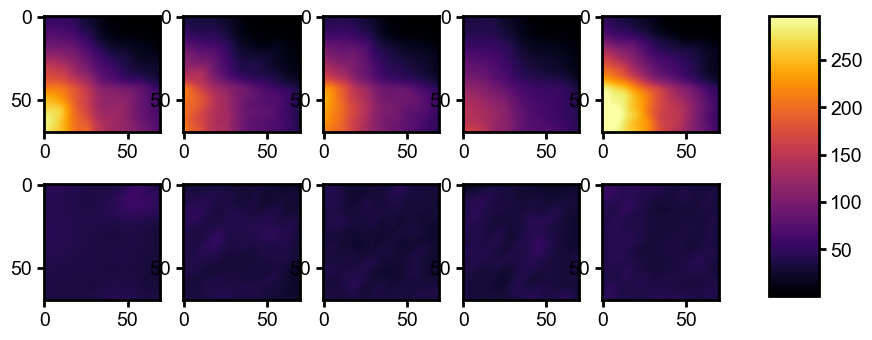

In [6]:
photon_count = 400
# crop_size = 80

initial_images = initial_measurements[photon_count]
final_images = final_measurements[photon_count]

# take center crop_size pixels
initial_images = initial_images[:, 10:80, -80:-10]
final_images = final_images[:, 10:80, -80:-10]

data_min = min(initial_images.min(), final_images.min())
data_max = max(initial_images.max(), final_images.max())

vmin = np.percentile(np.stack([initial_images, final_images]), 1)
vmax = np.percentile(np.stack([initial_images, final_images]), 99)

# plot 5 of the initial and final measurements
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs[0]):
    ax.imshow(initial_images[i], vmin=vmin, vmax=vmax, cmap='inferno')


for i, ax in enumerate(axs[1]):
    ax.imshow(final_images[i], vmin=vmin, vmax=vmax, cmap='inferno')

# show a shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0, 0].get_images()[0], cax=cbar_ax)


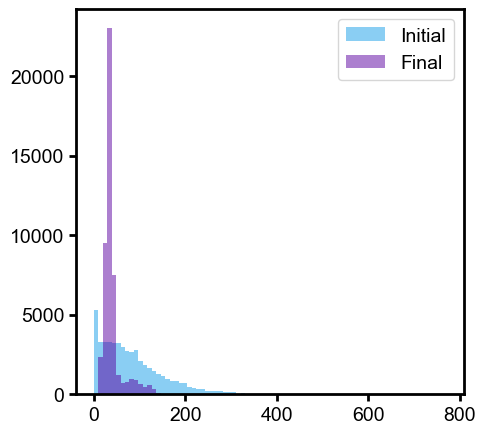

In [8]:
# histogram of the initial and final measurements
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(data_min, data_max, 80)

_ = axs.hist(initial_images[:10].ravel(), bins=bins, alpha=0.5, label='Initial')
_ = axs.hist(final_images[:10].ravel(), bins=bins, alpha=0.5, label='Final')
axs.legend()

In [10]:
patch_size = 25

initial_patches = extract_patches(initial_images, patch_size=patch_size, num_patches=5000, verbose=True)
final_patches = extract_patches(final_images, patch_size=patch_size, num_patches=5000, verbose=True)

initial_noisy_patches = add_noise(initial_patches)
final_noisy_patches = add_noise(final_patches)

initial_mi = estimate_mutual_information(initial_noisy_patches, clean_images=initial_patches, entropy_model='pixel_cnn', verbose=True)
final_mi = estimate_mutual_information(final_noisy_patches, clean_images=final_patches, entropy_model='pixel_cnn', verbose=True)

print('Initial MI: ', initial_mi)
print('Final MI: ', final_mi)

2024-01-23 09:53:56.975307: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 19.72


Epoch 1: 100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 1: validation NLL: 5.13


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 39.57it/s]


Epoch 2: validation NLL: 4.50


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


Epoch 3: validation NLL: 4.32


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 4: validation NLL: 5.21


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


Epoch 5: validation NLL: 5.20


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 6: validation NLL: 5.20


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 7: validation NLL: 5.20


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 8: validation NLL: 5.20


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Epoch 9: validation NLL: 5.20


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.51it/s]


Epoch 10: validation NLL: 5.20


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 11: validation NLL: 5.20


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 39.92it/s]


Epoch 12: validation NLL: 5.20


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.82it/s]


Epoch 13: validation NLL: 5.20


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 14: validation NLL: 5.20


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


Epoch 15: validation NLL: 5.20


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 40.01it/s]


Epoch 16: validation NLL: 5.20


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 17: validation NLL: 5.20


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


Epoch 18: validation NLL: 5.20


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 40.16it/s]


Epoch 19: validation NLL: 5.20


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 39.73it/s]


Epoch 20: validation NLL: 5.20


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


Epoch 21: validation NLL: 5.20


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.86it/s]


Epoch 22: validation NLL: 5.20


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Epoch 23: validation NLL: 5.20


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 24: validation NLL: 5.20


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


Epoch 25: validation NLL: 5.20


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 26: validation NLL: 5.20


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]


Epoch 27: validation NLL: 5.20


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.80it/s]


Epoch 28: validation NLL: 5.20


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.60it/s]


Epoch 29: validation NLL: 5.21


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.69it/s]


Epoch 30: validation NLL: 5.20


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 31: validation NLL: 5.20


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 32: validation NLL: 5.20


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 33: validation NLL: 5.20


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 34: validation NLL: 5.20


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.52it/s]


Epoch 35: validation NLL: 5.20


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.13it/s]


Epoch 36: validation NLL: 5.20


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 37: validation NLL: 5.20


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.70it/s]


Epoch 38: validation NLL: 5.20


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 40.22it/s]


Epoch 39: validation NLL: 5.20


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 40: validation NLL: 5.20


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 41: validation NLL: 5.20


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.88it/s]


Epoch 42: validation NLL: 5.20


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 43: validation NLL: 5.20
Estimated H(Y|X) = 3.409 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.312 differential entropy/pixel
Estimated I(Y;X) = 1.303 bits/pixel
Initial validation NLL: 5.69


Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Epoch 1: validation NLL: 3.25


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch 2: validation NLL: 3.23


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 3: validation NLL: 3.22


Epoch 4: 100%|██████████| 100/100 [00:02<00:00, 39.95it/s]


Epoch 4: validation NLL: 3.20


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Epoch 5: validation NLL: 3.19


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 39.66it/s]


Epoch 6: validation NLL: 3.19


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


Epoch 7: validation NLL: 3.21


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Epoch 8: validation NLL: 3.23


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 39.91it/s]


Epoch 9: validation NLL: 3.19


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Epoch 10: validation NLL: 3.18


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 11: validation NLL: 3.19


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s]


Epoch 12: validation NLL: 3.19


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 13: validation NLL: 3.19


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch 14: validation NLL: 3.19


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 15: validation NLL: 3.19


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 39.67it/s]


Epoch 16: validation NLL: 3.20


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 39.18it/s]


Epoch 17: validation NLL: 3.19


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 18: validation NLL: 3.18


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Epoch 19: validation NLL: 3.19


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 20: validation NLL: 3.18


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Epoch 21: validation NLL: 3.19


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


Epoch 22: validation NLL: 3.19


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


Epoch 23: validation NLL: 3.19


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 24: validation NLL: 3.19


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 25: validation NLL: 3.19


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


Epoch 26: validation NLL: 3.18


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 27: validation NLL: 3.18


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 28: validation NLL: 3.19


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 29: validation NLL: 3.18


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Epoch 30: validation NLL: 3.18


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Epoch 31: validation NLL: 3.19


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Epoch 32: validation NLL: 3.19


Epoch 33: 100%|██████████| 100/100 [00:02<00:00, 39.39it/s]


Epoch 33: validation NLL: 3.18


Epoch 34: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


Epoch 34: validation NLL: 3.18


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.04it/s]


Epoch 35: validation NLL: 3.18


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 39.30it/s]


Epoch 36: validation NLL: 3.18


Epoch 37: 100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


Epoch 37: validation NLL: 3.18


Epoch 38: 100%|██████████| 100/100 [00:02<00:00, 39.40it/s]


Epoch 38: validation NLL: 3.19


Epoch 39: 100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


Epoch 39: validation NLL: 3.19


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Epoch 40: validation NLL: 3.19


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 39.34it/s]


Epoch 41: validation NLL: 3.19


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch 42: validation NLL: 3.18


Epoch 43: 100%|██████████| 100/100 [00:02<00:00, 39.31it/s]


Epoch 43: validation NLL: 3.19


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 39.23it/s]


Epoch 44: validation NLL: 3.19


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 39.84it/s]


Epoch 45: validation NLL: 3.19


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 39.38it/s]


Epoch 46: validation NLL: 3.18


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 39.36it/s]


Epoch 47: validation NLL: 3.19


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


Epoch 48: validation NLL: 3.19


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch 49: validation NLL: 3.19


Epoch 50: 100%|██████████| 100/100 [00:02<00:00, 39.81it/s]


Epoch 50: validation NLL: 3.19


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


Epoch 51: validation NLL: 3.21


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Epoch 52: validation NLL: 3.19


Epoch 53: 100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


Epoch 53: validation NLL: 3.19


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 54: validation NLL: 3.19


Epoch 55: 100%|██████████| 100/100 [00:02<00:00, 39.41it/s]


Epoch 55: validation NLL: 3.19


Epoch 56: 100%|██████████| 100/100 [00:02<00:00, 39.86it/s]


Epoch 56: validation NLL: 3.19


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 39.69it/s]


Epoch 57: validation NLL: 3.19


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 58: validation NLL: 3.19


Epoch 59: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Epoch 59: validation NLL: 3.19


Epoch 60: 100%|██████████| 100/100 [00:02<00:00, 39.43it/s]


Epoch 60: validation NLL: 3.19
Estimated H(Y|X) = 3.145 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.183 differential entropy/pixel
Estimated I(Y;X) = 0.056 bits/pixel
Initial MI:  1.3034792
Final MI:  0.055559684


```
Initial MI:  1.3034792
Final MI:  0.055559684
```